# Bios 8366 Final Project: 30-day readmission risk prediction
## Leigh Anne Tang and Thomas Brown

# Introduction

Among its various provisions, the Affordable Care Act of 2012 established the Hospital Readmission Reduction Program (HRRP), a Medicare value-based purchasing program[1]. The program’s goal is to incentivize hospitals to improve their quality of care by minimizing the number of unplanned readmissions, as unplanned readmissions are costly and may lead to adverse events. Medicare creates such incentives by financially penalizing hospitals with “worse than expected” 30-day readmission rates. In response, hospitals and researchers have since devoted significant resources to reducing unplanned readmission[1-2].

Due to their scalability and potential cost-efficiency, clinical prediction models have been an attractive tool for solving the readmission problem[3]. If a model can predict if a patient that is about to be discharged will likely be readmitted in the next 30-days, the healthcare team can revise its care plan and potentially avoid an adverse event. As such, hospital, research, and industrial organizations have developed machine learning methods and models to predict 30-day readmission. Models have varied from the type of data (e.g., administrative data, electronic health record (EHR) data) to the type of model (e.g., interpretable regression models, black-box deep learning models) to the type of readmission (e.g., condition-specific readmission, age-specific readmission, all-cause readmission)[3]. In this notebook, we developed models to predict all-cause 30-day readmission for adult patients (18 years and older) using de-identified EHR data from Vanderbilt University Medical Center (VUMC).

# Methods

This study was limited to individuals who were at least 18 years of age at the time of admission. We modeled the data at the admission level, following the approach of Walsh et al.[4]. Though models have varied in the type of data considered and the time at which prediction is implemented into the clinical workflow[3-4]; here, we considered the scenario in which the model produces a prediction immediately prior to the patient’s discharge. We assumed all the data pertaining to the patient’s current admission was available at this time, as well as limited information from prior visits. We made these assumptions to investigate the importance of the different sources of information predicting the outcome. Since our models incorporated information from previous visits, individuals’ first admission to VUMC were excluded from admission instances. 

We defined a 30-day readmission as any hospital admission occurring within thirty days of discharge from the previous hospital admission. Admissions were considered as separate events (i.e., multiple admissions could pertain to the same individual). Admissions resulting in death were excluded.

## Data Cleaning and Reshaping

This project involved categorical data (CPT, ICD9, lab, medications data) and continuous data (BMI, blood pressure, and estimated glomerular filtration rate or eGFR data). We summarized categorical data by taking the unique number of occurrences for each category in a given admission. In the CPT and ICD9 data, the unique number of CPTs and ICDs were summarized for each admission. In the lab and medication data, the total number of unique lab names and drug names respectively were summarized for each admission.

We summarized most continuous data (BMI, diastolic blood pressure and systolic blood  pressure) by calculating the median value recorded during admission. We also calculated the change in BMI during admission. eGFR was categorized as potentially indicative of kidney failure if less than 15, kidney disease if 15-59, early kidney disease if 60-89, and normal otherwise (https://www.kidney.org/atoz/content/gfr). We summarized eGFR results by taking the most severe outcome recorded during the given admission.

We also noted several other variables that might be predictive of 30-day readmission. These variables included sex, race, days since last discharge, length of stay, and age at admission. An ED indicator was added for admissions involving services in the emergency department (emergency general surgery or emergency medicine). An indicator was added if the current admission occurred within 30 days of a previous admission. We added a variable for the number of previous admissions as a measure of healthcare utilization. A pregnancy indicator (from BMI data) was flagged if an individual was noted to be pregnant at any point in the admission.

## Feature and outcome definition

Each model considers at least a subset, depending on the imputation method, of the following variables:
1. If current admission results in subsequent 30-day readmission (outcome variable)
2. Sex
3. Race
4. Days since last discharge
5. Length of stay
6. Readmission (1 if admission occurred within 30 days of previous admission, 0 otherwise)
7. Age at admission
8. ED services (1 if admission involved ED services, 0 otherwise)
9. Number of previous admissions
10. Number of previous admissions involving ED services
11. Number of unique CPT codes from current admission
12. Number of unique ICD codes from previous admission
13. Number of unique ICD codes from current admission
14. Number of unique lab names from current admission
15. Number of unique medication names from current admission
16. Median systolic blood pressure from current admission
17. Median diastolic blood pressure from current admission
19. Median BMI from current admission
20. Median BMI from previous admission
21. Change in BMI during current admission (max BMI - min BMI)
23. Pregnancy Indicator (1 if pregnant based on BMI data at any point in admission, 0 otherwise)
24. Most severe category of eGFR value from current admission
25. Imputation indicator for median BMI from previous admission
26. Imputation indicator for change in BMI during current admission (max BMI - min BMI)
27. Imputation indicator for median BMI from current admission
28. Imputation indicator for median systolic blood pressure
29. Imputation indicator for median diastolic blood pressure


In [1]:
import pandas as pd
import os
import csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### converts date column to datetime format, removes NaTs
def clean_dates(df, date_col):
    
    df[date_col] = pd.to_datetime(df[date_col], errors = 'coerce')
    df = df.loc[df[date_col].notna()]

    return df

### only join data pertaining to each admission
def merge_adm(adm_df, new_df, new_date_col):
    
    adm_new = adm_df.merge(new_df, how = 'left', on = 'RUID')
    adm_new = adm_new.loc[(adm_new[new_date_col] >= adm_new.Admission_date) & (
        adm_new[new_date_col] <= adm_new.DISCHARGE_DATE)]
    
    return adm_new


path = '../../Data'


In [ ]:
### load data into dictionary
dat_dict = dict()
for f in [f for f in os.scandir(path) if f.name.endswith('csv')]:

    print(f.name)
    
    try:
        d = pd.read_csv(f.path, quoting=csv.QUOTE_NONE)
    except:
        d = pd.read_csv(f.path, quoting=csv.QUOTE_NONE, encoding='unicode_escape')
    
    # get file type from file name
    f_type = (f.name
              .replace('FONNESBECK_', '')
              .replace('_20151202.csv', '')
             )
    
    dat_dict.update({f_type: d})
    
dat_dict.keys()  


In [3]:
### look at first 5 rows of each dataset
for k in dat_dict.keys():
    
    print(f''' {k}    
    shape: {dat_dict[k].shape}
    unique RUIDs: {dat_dict[k].RUID.nunique()}
    
    {dat_dict[k].head()}
    ''')


 CPT    
    shape: (3827388, 3)
    unique RUIDs: 7891
    
           RUID CPT_Code  Event_date
0  50135262    00001  11/28/2004
1  50135262    00005  05/03/2012
2  50135262    00025  02/08/2007
3  50135262    00025  11/16/2004
4  50135262    00030  02/08/2007
    
 BMI    
    shape: (262906, 6)
    unique RUIDs: 6634
    
           RUID    BMI    Date_BMI  BMI_Weight  BMI_Height  Pregnancy_Indicator
0  50135262  41.43  01/09/2005      119.98      170.18                    0
1  50135262  22.86  02/11/2011       70.00      175.00                    0
2  50135262  43.07  02/12/2011      131.90      175.00                    0
3  50135262  43.06  02/12/2011      131.86      175.00                    0
4  50135262  41.47  02/12/2011      127.00      175.00                    0
    
 ICD9    
    shape: (2052067, 3)
    unique RUIDs: 7935
    
           RUID ICD9_Code  Event_date
0  50135262     00.40  08/04/2007
1  50135262     00.46  08/04/2007
2  50135262     00.66  08/04/2007
3  50

## Admission/Transfer/Discharge Data

In [4]:
### admission and transfer data
### admission_date = date of admission; discharge_date = date of discharge
### event_date = date of row event (admit, transfer, discharge)

## determine periods of admission, flag if is readmission within 30 days of another
adt = dat_dict['ADT'].copy()
adt = adt.loc[(adt['Admission_date'].notna()) & (adt['DISCHARGE_DATE'].notna())]
adt['Admission_date'] = pd.to_datetime(adt['Admission_date'])
adt['DISCHARGE_DATE'] = pd.to_datetime(adt['DISCHARGE_DATE'])

# unique admissions
uniq_adm = (adt[['RUID', 'Admission_date', 'DISCHARGE_DATE']]
            .drop_duplicates()
            .sort_values(by=['RUID', 'Admission_date'])
            .reset_index(drop=True)
           )

uniq_adm['prev_discharge_date'] = uniq_adm.groupby('RUID')['DISCHARGE_DATE'].shift(1)
uniq_adm['days_since_last_discharge'] = (uniq_adm['Admission_date'] - uniq_adm['prev_discharge_date']).dt.days
uniq_adm['length_of_stay'] = (uniq_adm['DISCHARGE_DATE'] - uniq_adm['Admission_date']).dt.days

# remove admissions occurring within current admission (assuming overlooked in data pull)
uniq_adm = uniq_adm.loc[~(uniq_adm.days_since_last_discharge < 0)]

# flag 30-day readmissions
uniq_adm['readm'] = (uniq_adm['days_since_last_discharge'] <= 30).astype(int)

uniq_adm = uniq_adm.drop(columns='prev_discharge_date')

uniq_adm.head()


,RUID,Admission_date,DISCHARGE_DATE,days_since_last_discharge,length_of_stay,readm
0,50135262,2007-02-08,2007-02-12,NaN,4,0
1,50135262,2007-08-03,2007-08-06,172.0,3,0
2,50135262,2007-08-28,2007-08-29,22.0,1,1
3,50135262,2008-02-24,2008-02-28,179.0,4,0
4,50135262,2008-04-12,2008-04-13,44.0,1,0


In [5]:
### add demos
demos = dat_dict['phenotype'].copy()
demos = clean_dates(demos, 'DOB')
demos['DOD'] = pd.to_datetime(demos['DOD'])

adm_demos = demos.merge(uniq_adm)

# calculate age at admission
adm_demos['age_at_adm'] = np.floor((adm_demos['Admission_date'] - adm_demos['DOB'])/np.timedelta64(1,'Y'))

# remove admissions resulting in death
adm_demos['death_during_adm'] = adm_demos.apply(lambda x: x['DOD'] >= x['Admission_date'] and x['DOD'] <= x['DISCHARGE_DATE'], axis = 1)
adm_demos = adm_demos.loc[~adm_demos.death_during_adm]
                                 
adm_demos = adm_demos.drop(columns = ['DOB', 'DOD', 'death_during_adm'])

print(f'''
Unique RUIDs w/ admissions: {adm_demos.RUID.nunique()}
Unique RUIDs w/ 30-day readmission: {adm_demos.loc[adm_demos.readm==1].RUID.nunique()}

Total admissions: {adm_demos.shape[0]}
Total 30-day readmissions: {adm_demos.loc[adm_demos.readm==1].shape[0]}
''')

adm_demos.head()



Unique RUIDs w/ admissions: 7741
Unique RUIDs w/ 30-day readmission: 2506

Total admissions: 29146
Total 30-day readmissions: 8147



,RUID,Sex,Race,Admission_date,DISCHARGE_DATE,days_since_last_discharge,length_of_stay,readm,age_at_adm
0,50135262,F,W,2007-02-08,2007-02-12,NaN,4,0,57.0
1,50135262,F,W,2007-08-03,2007-08-06,172.0,3,0,57.0
2,50135262,F,W,2007-08-28,2007-08-29,22.0,1,1,57.0
3,50135262,F,W,2008-02-24,2008-02-28,179.0,4,0,58.0
4,50135262,F,W,2008-04-12,2008-04-13,44.0,1,0,58.0


## Clean Repeated Data
CPT, ICD, BMI, LAB, BP, EGFR, Meds

In [6]:
### CPT, unique CPT codes on each date
cpt = dat_dict['CPT'].copy()
cpt = clean_dates(cpt, 'Event_date')
uniq_cpt = cpt[['RUID', 'CPT_Code', 'Event_date']].drop_duplicates()
uniq_cpt.head()


,RUID,CPT_Code,Event_date
0,50135262,00001,2004-11-28
1,50135262,00005,2012-05-03
2,50135262,00025,2007-02-08
3,50135262,00025,2004-11-16
4,50135262,00030,2007-02-08


In [7]:
### ICD, unique ICD codes on each date
icd = dat_dict['ICD9'].copy()
icd = clean_dates(icd, 'Event_date')
uniq_icd = icd[['RUID', 'ICD9_Code', 'Event_date']].drop_duplicates()
uniq_icd.head()


,RUID,ICD9_Code,Event_date
0,50135262,00.40,2007-08-04
1,50135262,00.46,2007-08-04
2,50135262,00.66,2007-08-04
3,50135262,00.81,2012-09-17
4,50135262,00.82,2012-09-17


In [8]:
### Lab, unique lab names on each date
lab = dat_dict['LAB'].copy()
lab = clean_dates(lab, 'Lab_date')
uniq_lab = lab[['RUID', 'Lab_date', 'Lab_name']].drop_duplicates()
uniq_lab.head()


,RUID,Lab_date,Lab_name
0,50135262,2008-04-13,%SAT
1,50135262,2007-02-08,ABO
2,50135262,2008-02-24,ABO
3,50135262,2007-02-08,AN-GAP
4,50135262,2011-02-11,AN-GAP


In [9]:
### medications, unique drug names on each date
med = dat_dict['MED'].copy()
med = clean_dates(med, 'Entry_Date')
uniq_med = med[['RUID', 'Entry_Date', 'Drug_Name']].drop_duplicates()
uniq_med.head()


,RUID,Entry_Date,Drug_Name
0,50135262,2011-02-13,ACETAMINOPHEN : TYLENOL
1,50135262,2012-05-23,ACETAMINOPHEN : TYLENOL
3,50135262,2010-10-29,ACETAMINOPHEN : TYLENOL
5,50135262,2011-02-11,ACETAMINOPHEN ORAL SOLUTION
6,50135262,2008-02-26,ACETAMINOPHEN: TYLENOL


In [10]:
### BMI, keep values between 15 and 50?
bmi = dat_dict['BMI'].copy()
bmi = clean_dates(bmi, 'Date_BMI')
bmi = bmi.loc[(bmi.BMI >= 15) & (bmi.BMI <= 50)]
bmi.head()


,RUID,BMI,Date_BMI,BMI_Weight,BMI_Height,Pregnancy_Indicator
0,50135262,41.43,2005-01-09,119.98,170.18,0
1,50135262,22.86,2011-02-11,70.00,175.00,0
2,50135262,43.07,2011-02-12,131.90,175.00,0
3,50135262,43.06,2011-02-12,131.86,175.00,0
4,50135262,41.47,2011-02-12,127.00,175.00,0


<AxesSubplot:>

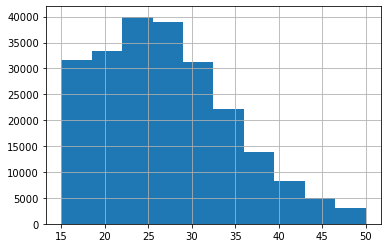

In [11]:
bmi.BMI.hist()

In [12]:
### blood pressure, keep if systolic between 70 and 250, AND diastolic between 30 and 120
bp = dat_dict['BP'].copy()
bp = clean_dates(bp, 'Measure_date')
bp = bp.loc[(bp.SYSTOLIC <= 250) & (bp.SYSTOLIC >= 70) & (bp.DIASTOLIC >= 30) & (bp.DIASTOLIC <= 120)]
bp.head()


,RUID,SYSTOLIC,DIASTOLIC,Measure_date
0,50135262,150,80,2005-01-09
1,50135262,137,77,2007-02-08
2,50135262,137,78,2007-02-08
3,50135262,190,78,2007-02-08
4,50135262,190,77,2007-02-08


<AxesSubplot:>

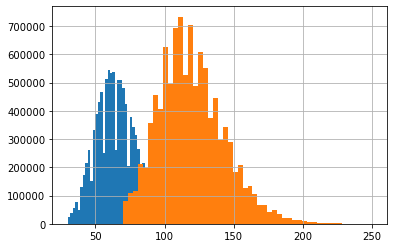

In [13]:
bp.DIASTOLIC.hist(bins = 50)
bp.SYSTOLIC.hist(bins = 50)


In [14]:
### eGFR, keep if between 0 and 200
egfr = dat_dict['EGFR'].copy()
egfr = clean_dates(egfr, 'egfr_date')
egfr = egfr.loc[(egfr.EGFR >= 0) & (egfr.EGFR <= 200)]

# categorize eGFR values as follows
# normal: >=90, early kidney disease: 60-89, kidney disease: 15-59, kidney failure: <15
egfr['EGFR_category'] = np.where((egfr['EGFR'] >= 60) & (egfr['EGFR'] <= 89), 'early_kidney_disease',
                                 np.where((egfr['EGFR'] >= 15) & (egfr['EGFR'] <= 59), 'kidney_disease',
                                          np.where(egfr['EGFR'] < 15, 'kidney_failure', 
                                                   'normal')))

egfr['EGFR_category'] = egfr['EGFR_category'].map({'normal': 0,
                                                   'early_kidney_disease': 1,
                                                   'kidney_disease': 2,
                                                   'kidney_failure': 3})

egfr.head()


,RUID,EGFR,egfr_date,EGFR_category
0,50135262,123.68000,2007-02-08,0
1,50135262,123.67783,2007-02-08,0
2,50135262,76.40173,2011-02-11,1
3,50135262,76.40000,2011-02-11,1
4,50135262,78.64000,2011-02-12,1


<AxesSubplot:>

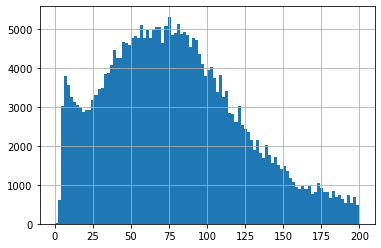

In [15]:
egfr.EGFR.hist(bins=100)

<AxesSubplot:>

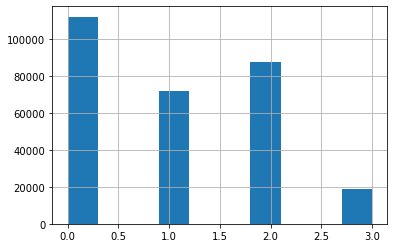

In [16]:
egfr.EGFR_category.hist()

## Merge Repeated Data and Admissions

In [17]:
## flag admissions with services in ED (emergency general surgery (EGS) or emergency medicine (EMR))
ed_admission = adt[['RUID', 'Admission_date', 'DISCHARGE_DATE', 'SRV_CODE']].drop_duplicates()
ed_admission['ED'] = ed_admission['SRV_CODE'].apply(lambda x: 1 if x in ['EGS', 'EMR'] else 0)
ed_admission = (ed_admission
                .groupby(['RUID', 'Admission_date', 'DISCHARGE_DATE'])['ED'].max()
                .reset_index()
               )

adm_ed = adm_demos.merge(ed_admission, how='left')
adm_ed = adm_ed.set_index(['RUID', 'Admission_date', 'DISCHARGE_DATE'])

adm_ed.head()


Sex Race  days_since_last_discharge  \
RUID     Admission_date DISCHARGE_DATE                                       
50135262 2007-02-08     2007-02-12       F    W                        NaN   
         2007-08-03     2007-08-06       F    W                      172.0   
         2007-08-28     2007-08-29       F    W                       22.0   
         2008-02-24     2008-02-28       F    W                      179.0   
         2008-04-12     2008-04-13       F    W                       44.0   

                                        length_of_stay  readm  age_at_adm  ED  
RUID     Admission_date DISCHARGE_DATE                                         
50135262 2007-02-08     2007-02-12                   4      0        57.0   0  
         2007-08-03     2007-08-06                   3      0        57.0   0  
         2007-08-28     2007-08-29                   1      1        57.0   1  
         2008-02-24     2008-02-28                   4      0        58.0   0  
         2008-04-12     2008-04-13                   1      0        58.0   0

In [18]:
##### unique counts of codes/tests occurring during admission
## CPTs
adm_cpt = merge_adm(adm_df = adm_demos, new_df = uniq_cpt, new_date_col = 'Event_date')
adm_cpt = (adm_cpt
           .groupby(['RUID', 'Admission_date', 'DISCHARGE_DATE'])['CPT_Code'].nunique()
           .reset_index(name='n_CPT')
           .set_index(['RUID', 'Admission_date', 'DISCHARGE_DATE'])
          )

## ICDs
adm_icd = merge_adm(adm_df = adm_demos, new_df = uniq_icd, new_date_col = 'Event_date')
adm_icd = (adm_icd
           .groupby(['RUID', 'Admission_date', 'DISCHARGE_DATE'])['ICD9_Code'].nunique()
           .reset_index(name = 'n_ICD')
           .set_index(['RUID', 'Admission_date', 'DISCHARGE_DATE'])
          )

## Labs
adm_lab = merge_adm(adm_df = adm_demos, new_df = uniq_lab, new_date_col = 'Lab_date')
adm_lab = (adm_lab
           .groupby(['RUID', 'Admission_date', 'DISCHARGE_DATE'])['Lab_name'].nunique()
           .reset_index(name = 'n_Lab')
           .set_index(['RUID', 'Admission_date', 'DISCHARGE_DATE'])
          )

## Meds
adm_med = merge_adm(adm_df = adm_demos, new_df = uniq_med, new_date_col = 'Entry_Date')
adm_med = (adm_med
           .groupby(['RUID', 'Admission_date', 'DISCHARGE_DATE'])['Drug_Name'].nunique()
           .reset_index(name = 'n_Med')
           .set_index(['RUID', 'Admission_date', 'DISCHARGE_DATE'])
          )


In [19]:
# BP
##### median of measurements during admission
adm_bp = merge_adm(adm_df = adm_demos, new_df = bp, new_date_col = 'Measure_date')
adm_bp = (adm_bp
          .groupby(['RUID', 'Admission_date', 'DISCHARGE_DATE'])
          .agg(median_systolic = ('SYSTOLIC', 'median'),
               median_diastolic = ('DIASTOLIC', 'median'))
          .reset_index()
          .set_index(['RUID', 'Admission_date', 'DISCHARGE_DATE'])
         )

# BMI
##### median of measurements during admission
adm_bmi = merge_adm(adm_df = adm_demos, new_df = bmi, new_date_col = 'Date_BMI')
adm_bmi = (adm_bmi
           .groupby(['RUID', 'Admission_date', 'DISCHARGE_DATE'])
           .agg(median_BMI = ('BMI', 'median'),
                min_BMI = ('BMI', 'min'),
                max_BMI = ('BMI', 'max'),
                preg = ('Pregnancy_Indicator', 'max'))
           .reset_index()
           .set_index(['RUID', 'Admission_date', 'DISCHARGE_DATE'])
          )
adm_bmi['change_in_BMI'] = adm_bmi['max_BMI'] - adm_bmi['min_BMI']
adm_bmi = adm_bmi.drop(columns = ['min_BMI', 'max_BMI'])

# EGFR
##### most abnormal EGFR value during admission
adm_egfr = merge_adm(adm_df = adm_demos, new_df = egfr, new_date_col = 'egfr_date')
adm_egfr = (adm_egfr
            .groupby(['RUID', 'Admission_date', 'DISCHARGE_DATE'])['EGFR_category'].max()
            .reset_index(name = 'max_EGFR')
            .set_index(['RUID', 'Admission_date', 'DISCHARGE_DATE'])
           )


## Missing Data
We made a few assumptions about specific types of missing data. If no ICD or CPT codes were associated with the previous admission, we assumed there were no codes associated with the admission. We assumed normal eGFR results in the absence of eGFR testing, and no pregnancy in the absence of a pregnancy indicator in the BMI data.

In [20]:
### joining all admission data
adm_dat = (adm_ed
           .join(adm_cpt)
           .join(adm_icd)
           .join(adm_lab)
           .join(adm_med)
           .join(adm_bp)
           .join(adm_bmi)
           .join(adm_egfr)
          ).sort_values(['RUID', 'Admission_date'])

adm_dat[['n_CPT', 'n_ICD', 'n_Lab', 'n_Med']] = adm_dat[['n_CPT', 'n_ICD', 'n_Lab', 'n_Med']].fillna(0)

# assume not pregnant if NA
adm_dat['preg'].fillna(0, inplace = True)

# assume normal eGFR if NA
adm_dat['max_EGFR'].fillna(0, inplace = True)

# ICD codes from previous visit
adm_dat['n_prev_ICD'] = adm_dat.groupby('RUID')['n_ICD'].shift(1)
adm_dat['n_prev_ICD'].fillna(0, inplace = True)

# number of previous admissions (includes admissions with ED)
adm_dat['n_prev_adm'] = adm_dat.groupby('RUID').cumcount()

# number of previous ED visits
adm_dat['n_prev_ED_adm'] = adm_dat.groupby('RUID')['ED'].cumsum()

# outcome variable: if this visit results in readmission within 30 days
adm_dat['will_be_readm'] = adm_dat.groupby(['RUID'])['readm'].shift(-1)
adm_dat['will_be_readm'].fillna(0, inplace = True)

# # set NA value for admissions that will be excluded from dataset (so will not be imputed)
# adm_dat['days_since_last_discharge'].fillna(-9, inplace = True)

# previous visit's median BMI
adm_dat['prev_median_BMI'] = adm_dat.groupby('RUID')['median_BMI'].shift(1)

# filter for admissions with at least one previous documented visit
adm_dat = adm_dat.loc[adm_dat.n_prev_adm >= 1]

print(adm_dat.shape)
adm_dat.head()

(21405, 22)


Sex Race  days_since_last_discharge  \
RUID     Admission_date DISCHARGE_DATE                                       
50135262 2007-08-03     2007-08-06       F    W                      172.0   
         2007-08-28     2007-08-29       F    W                       22.0   
         2008-02-24     2008-02-28       F    W                      179.0   
         2008-04-12     2008-04-13       F    W                       44.0   
         2010-10-28     2010-10-29       F    W                      928.0   

                                        length_of_stay  readm  age_at_adm  ED  \
RUID     Admission_date DISCHARGE_DATE                                          
50135262 2007-08-03     2007-08-06                   3      0        57.0   0   
         2007-08-28     2007-08-29                   1      1        57.0   1   
         2008-02-24     2008-02-28                   4      0        58.0   0   
         2008-04-12     2008-04-13                   1      0        58.0   0   
         2010-10-28     2010-10-29                   1      0        61.0   0   

                                        n_CPT  n_ICD  n_Lab  ...  \
RUID     Admission_date DISCHARGE_DATE                       ...   
50135262 2007-08-03     2007-08-06       46.0   27.0   34.0  ...   
         2007-08-28     2007-08-29       26.0   20.0   38.0  ...   
         2008-02-24     2008-02-28       47.0   28.0   63.0  ...   
         2008-04-12     2008-04-13       20.0   12.0   27.0  ...   
         2010-10-28     2010-10-29       22.0    8.0   31.0  ...   

                                        median_diastolic  median_BMI  preg  \
RUID     Admission_date DISCHARGE_DATE                                       
50135262 2007-08-03     2007-08-06                  61.0      45.025   0.0   
         2007-08-28     2007-08-29                  60.0      46.230   0.0   
         2008-02-24     2008-02-28                  74.0      47.140   0.0   
         2008-04-12     2008-04-13                  66.0      47.580   0.0   
         2010-10-28     2010-10-29                  52.0         NaN   0.0   

                                        change_in_BMI  max_EGFR  n_prev_ICD  \
RUID     Admission_date DISCHARGE_DATE                                        
50135262 2007-08-03     2007-08-06               0.90       1.0        35.0   
         2007-08-28     2007-08-29              12.53       0.0        27.0   
         2008-02-24     2008-02-28               0.00       2.0        20.0   
         2008-04-12     2008-04-13               0.00       1.0        28.0   
         2010-10-28     2010-10-29                NaN       0.0        12.0   

                                        n_prev_adm  n_prev_ED_adm  \
RUID     Admission_date DISCHARGE_DATE                              
50135262 2007-08-03     2007-08-06               1              0   
         2007-08-28     2007-08-29               2              1   
         2008-02-24     2008-02-28               3              1   
         2008-04-12     2008-04-13               4              1   
         2010-10-28     2010-10-29               5              1   

                                        will_be_readm  prev_median_BMI  
RUID     Admission_date DISCHARGE_DATE                                  
50135262 2007-08-03     2007-08-06                1.0              NaN  
         2007-08-28     2007-08-29                0.0           45.025  
         2008-02-24     2008-02-28                0.0           46.230  
         2008-04-12     2008-04-13                0.0           47.140  
         2010-10-28     2010-10-29                0.0           47.580  

[5 rows x 22 columns]

In [21]:
adm_dat.isna().sum()

Sex                             0
Race                            0
days_since_last_discharge       0
length_of_stay                  0
readm                           0
age_at_adm                      0
ED                              0
n_CPT                           0
n_ICD                           0
n_Lab                           0
n_Med                           0
median_systolic              1577
median_diastolic             1577
median_BMI                   6527
preg                            0
change_in_BMI                6527
max_EGFR                        0
n_prev_ICD                      0
n_prev_adm                      0
n_prev_ED_adm                   0
will_be_readm                   0
prev_median_BMI              6716
dtype: int64

In [22]:
# save to avoid recomputing
adm_dat.to_csv('adm_dat.csv', index=False)

In [2]:
# read in data
adm_dat = pd.read_csv('adm_dat.csv')

## Missing Data Imputation

Missing blood pressure and BMI values were accounted for using four different methods:

1. Imputation using the mean
2. Imputation using the most frequent value
3. Multiple imputation by chained equations (MICE)
4. K-nearest neighbor (KNN) imputation (k = 2)
5. Dropping columns with missing values

Data were independently imputed across the 75% training and 25% test sets. These methods for handling missing data were each evaluated in the model building process.

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, MissingIndicator, KNNImputer, IterativeImputer

def impute_datasets(imp, X_train, X_test, imp_cols):
    
    ind_cols = [x + "_ind" for x in imp_cols]
    
    imp = imp.fit(X_train)
    
    idx = X_train.index
    train = X_train.copy()
    train = imp.transform(train)
    train = pd.DataFrame(data=train, columns=(list(X_train.columns) + ind_cols), index=idx)
    
    idx = X_test.index
    test = X_test.copy()
    test = imp.transform(test)
    test = pd.DataFrame(data=test, columns=(list(X_test.columns) + ind_cols), index=idx)
    
    return train, test

# separate predictors and outcome
X = adm_dat.copy()
y = X.pop('will_be_readm')

# categorize race and sex
label_r = LabelEncoder()
label_r = label_r.fit(X['Race'])
X['Race'] = label_r.transform(X['Race'])

label_s = LabelEncoder()
label_s = label_r.fit(X['Sex'])
X['Sex'] = label_r.transform(X['Sex'])

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)


In [4]:
# columns with missing values
missing_cols = list(X_train.columns[X_train.isna().sum()>0])

### Simple Imputation - mean
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
X_train_mean, X_test_mean = impute_datasets(imp_mean, X_train, X_test, missing_cols)

### Simple Imputation - most frequent
imp_freq = SimpleImputer(missing_values=np.nan, strategy='most_frequent', add_indicator=True)
X_train_freq, X_test_freq = impute_datasets(imp_freq, X_train, X_test, missing_cols)

### Multivariate Imputation - multivariate imputation by chained equations
imp_mice = IterativeImputer(missing_values=np.nan, add_indicator=True)
X_train_mice, X_test_mice = impute_datasets(imp_mice, X_train, X_test, missing_cols)

### KNN Imputation
imp_knn = KNNImputer(n_neighbors=2, add_indicator=True)
X_train_knn, X_test_knn = impute_datasets(imp_knn, X_train, X_test, missing_cols)

### Drop columns with missing values
X_train_drop = X_train[X.columns[(X.isna().sum() == 0).values]]
X_test_drop = X_test[X.columns[(X.isna().sum() == 0).values]]


# Models

Our goal was to compare the performances of random forest and gradient boosted tree classifiers using the various methods for handling missing data noted above. As such, we created a baseline logistic regression model that employed the most basic method for handling missing data: dropping columns with any missing values. We generated multiple random forest and gradient boosted trees classifiers using each imputation method.

Specifically, we implemented the following models (model – missing data method):

1. Baseline Logistic Regression Model – Dropping columns with missing values
2. Random Forest Classifier – Imputation using the mean
3. Random Forest Classifier – Imputation using the most frequent value
4. Random Forest Classifier – MICE
5. Random Forest Classifier – KNN imputation (k = 2)
6. Random Forest Classifier – Dropping columns with missing values
7. Gradient Boosted Tree Classifier – Imputation using the mean
8. Gradient Boosted Tree Classifier – Imputation using the most frequent value
9. Gradient Boosted Tree Classifier – MICE
10. Gradient Boosted Tree Classifier – KNN imputation (k = 2)
11. Gradient Boosted Tree Classifier – Dropping columns with missing values

We performed cross validation to tune hyperparameters of each random forest and gradient boosted tree classifier. For the random forest classifiers, we considered various combinations of the number of trees, maximum depth of trees, minimum samples required for a node, and minimum samples required for a leaf. For the gradient boosted tree classifiers, we considered multiple combinations of the maximum depth of trees, minimum child weights, shrinkage of step size, L1 regularization, and L2 regularization.

To compare model performance, we calculated accuracy, AUROC, precision, recall, F1-scores, and F-beta scores for each classifier. The F1 and F-beta scores are the harmonic mean of precision and recall, where F1 considers equal weighting and F-beta (with beta=2 here) increases the weight of recall. We include F-beta (where beta=2) in our evaluation to measure performance in the scenario in which false negatives, which could lead to more adverse outcomes for the patients, are less tolerable than false positives. We selected the most optimal random forest and gradient boosted tree classifiers using F-beta scores, which account for the F1-score as well as recall. 

In [7]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import shap
from sklearn.metrics import f1_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve
import itertools

## Random Forest


In [109]:
def randomforest_cv(X_train, y_train):
    
    clf = RandomForestClassifier()

    rf_cf = RandomizedSearchCV(clf, parameter_grid, 
                                   n_iter=50, cv=5, n_jobs=6)

    rf_cf.fit(X_train, y_train)
    
    return rf_cf

In [110]:
%%time
#### cross validation for each imputed dataset

# hyperparameters
n_estimators = [300, 350, 400, 650, 700, 800, 900]
max_depth = [9, 11, 13, 15, 17, 19]
min_samples_split = [2, 4, 6, 8, 10, 12]
min_samples_leaf = list(np.arange(1, 6))
oob_score = [True]

# Create the random grid
parameter_grid = {'n_estimators': n_estimators,
                  'max_depth': max_depth,
                  'min_samples_split': min_samples_split,
                  'min_samples_leaf': min_samples_leaf,
                  'oob_score': oob_score}

# imputed datasets
datasets = {'Drop': [X_train_drop, X_test_drop],
            'Mean': [X_train_mean, X_test_mean],
            'Freq': [X_train_freq, X_test_freq],
            'Mice': [X_train_mice, X_test_mice],
            'KNN': [X_train_knn, X_test_knn]}

rf_models = {}

for key in datasets.keys():
    
    xtrain, xtest = datasets[key]
    
    # train models on imputed datasets
    rfc_cv = randomforest_cv(xtrain, y_train)
    
    # store models
    rf_models[key] = rfc_cv

CPU times: user 55.8 s, sys: 986 ms, total: 56.8 s
Wall time: 52min 5s


In [111]:
for key in datasets.keys():
    model = rf_models[key]
    print(model.best_estimator_.get_params())
    print()

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 800, 'n_jobs': None, 'oob_score': True, 'random_state': None, 'verbose': 0, 'warm_start': False}

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 11, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 650, 'n_jobs': None, 'oob_score': True, 'random_state': None, 'verbose': 0, 'warm_start': False}

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 11, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4,

In [112]:
from sklearn import metrics

accs = []
aucs = []
precs = []
recs = []
f1s = []
fbs = []

for key in rf_models.keys():
    
    model = rf_models[key]
    
    #print(model.best_estimator_.get_params())
    
    _, xtest = datasets[key]
    
    preds = model.best_estimator_.predict(xtest)
    
    accs.append(model.best_estimator_.score(xtest, y_test))
    aucs.append(metrics.roc_auc_score(y_test, preds))
    precs.append(metrics.precision_score(y_test, preds))
    recs.append(metrics.recall_score(y_test, preds))
    f1s.append(f1_score(y_test, preds))
    fbs.append(metrics.fbeta_score(y_test, preds, beta=2))
    
rf_results = pd.DataFrame({
    'Imputation method': rf_models.keys(),
    'Accuracy': accs,
    'AUROC': aucs,
    'Precision': precs,
    'Recall': recs,
    'F1 score': f1s, 
    'F-beta score': fbs})

rf_results

,Imputation method,Accuracy,AUROC,Precision,Recall,F1 score,F-beta score
0,Drop,0.719544,0.593417,0.583113,0.271666,0.370650,0.304156
1,Mean,0.725149,0.596578,0.608635,0.268593,0.372708,0.302380
2,Freq,0.724589,0.596695,0.605227,0.270436,0.373832,0.304077
3,Mice,0.725149,0.598136,0.605978,0.274124,0.377486,0.307841
4,KNN,0.725710,0.601135,0.604194,0.283344,0.385774,0.317013


In [122]:
## best RF model
imp_method = 'KNN'
best_rf_model = [rf_models[imp_method].best_estimator_,
                 rf_models[imp_method].best_estimator_.get_params(),
                 datasets[imp_method]]

In [123]:
## save model
from joblib import dump, load
dump(best_rf_model[0], 'best_rf_model.joblib') 

['best_rf_model.joblib']

In [124]:
## load model

# rf_model = load('best_rf_model.joblib')
# imp_method = 'KNN'
# best_rf_model = [rf_model,
#                  rf_model.get_params(),
#                  datasets[imp_method]]

RandomForestClassifier(max_depth=15, min_samples_leaf=2, min_samples_split=4,
                       n_estimators=400, oob_score=True)

## Gradient Boosted Trees

In [113]:
import xgboost as xgb

#dtest = xgb.DMatrix(X_test, label=y_test)
def xgbc_CV(xgb_params, param_grid, xtrain, ytrain):
    
    min_error = np.inf
    best_params = None
    
    dtrain = xgb.DMatrix(xtrain, label=ytrain)

    for max_depth, min_child_weight, eta, alpha, lambda_val in param_grid:

        # Update our parameters
        xgb_params['max_depth'] = max_depth
        xgb_params['min_child_weight'] = min_child_weight
        xgb_params['eta'] = eta
        xgb_params['reg_alpha'] = alpha
        xgb_params['reg_lambda'] = lambda_val

        # Run CV
        cv_results = xgb.cv(
            xgb_params,
            dtrain,
            num_boost_round=50,
            nfold=5,
            metrics={'error'},
            early_stopping_rounds=3
        )
        
        # Update best score
        mean_error = cv_results['test-error-mean'].min()
        boost_rounds = cv_results['test-error-mean'].argmin()
        #print("\tError {} for {} rounds".format(mean_error, boost_rounds))
        if mean_error < min_error:
            min_error = mean_error
            best_params = (max_depth, min_child_weight, eta, alpha, lambda_val)

    print("Best params: {}, {}, {}, {}, {}, Min Error: {}".format(best_params[0],
                                                                  best_params[1],
                                                                  best_params[2],
                                                                  best_params[3],
                                                                  best_params[4],
                                                                  min_error))
    
    return best_params

In [114]:
%%time
### CV for each imputated dataset

# Create the random grid
max_depths = [4, 5, 6]
min_child_wghts = [1, 2, 3, 4, 5, 6]
etas = [0.1, 0.5, 1]
alphas = [0, 0.001, 0.01, 0.1, 1]
lambdas = [0, 0.001, 0.01, 0.1, 1]

hyp_params = [max_depths,
              min_child_wghts,
              etas,
              alphas,
              lambdas]

param_grid = list(itertools.product(*hyp_params))

# imputed datasets
datasets = {'Drop': [X_train_drop, X_test_drop],
            'Mean': [X_train_mean, X_test_mean],
            'Freq': [X_train_freq, X_test_freq],
            'Mice': [X_train_mice, X_test_mice],
            'KNN': [X_train_knn, X_test_knn]}

xgb_models = {}

for key in datasets.keys():
    
    # parameters
    xgb_params = {
            'max_depth': 5,
            'eta': 0.1,
            'objective': 'binary:hinge',
            'eval_metric': 'error',
            'colsample_bytree': 0.5,
            'reg_alpha' : 0,
            'reg_lambda' : 0
    }
    
    # imputed dataset
    xtrain, xtest = datasets[key]
    
    # parameters of best model
    best_params = xgbc_CV(xgb_params, param_grid, xtrain, y_train)

    # train best model
    max_depth, min_child_weight, eta, alpha, lambda_val = best_params

    xgb_params['max_depth'] = max_depth
    xgb_params['min_child_weight'] = min_child_weight
    xgb_params['eta'] = eta
    xgb_params['reg_alpha'] = alpha
    xgb_params['reg_lambda'] = lambda_val

    xgbc = xgb.XGBClassifier(**xgb_params)
    xgbc.fit(xtrain, y_train)

    # save best model
    xgb_models[key] = [xgbc, xgb_params]


Best params: 5, 4, 0.5, 0.1, 0.001, Min Error: 0.2736568513026192
Best params: 5, 5, 0.5, 0.001, 0.001, Min Error: 0.2728471735108384
Best params: 5, 2, 0.5, 1, 0.1, Min Error: 0.2732208112494919
Best params: 5, 5, 0.5, 0.001, 1, Min Error: 0.2734077077336376
Best params: 5, 4, 0.5, 1, 1, Min Error: 0.2739062471197626
CPU times: user 4h 14min 2s, sys: 1min 55s, total: 4h 15min 58s
Wall time: 32min 23s


In [117]:
from sklearn import metrics

accs = []
aucs = []
precs = []
recs = []
f1s = []
fbs = []

for key in xgb_models.keys():
    
    model, _ = xgb_models[key]
    
    #print(model.best_estimator_.get_params())
    
    _, xtest = datasets[key]
    
    preds = model.predict(xtest)
    
    accs.append(model.score(xtest, y_test))
    aucs.append(metrics.roc_auc_score(y_test, preds))
    precs.append(metrics.precision_score(y_test, preds))
    recs.append(metrics.recall_score(y_test, preds))
    f1s.append(f1_score(y_test, preds))
    fbs.append(metrics.fbeta_score(y_test, preds, beta=2))
    
xgb_results = pd.DataFrame({
    'Imputation method': xgb_models.keys(),
    'Accuracy': accs,
    'AUROC': aucs,
    'Precision': precs,
    'Recall': recs,
    'F1 score': f1s, 
    'F-beta score': fbs})

xgb_results

,Imputation method,Accuracy,AUROC,Precision,Recall,F1 score,F-beta score
0,Drop,0.709641,0.587341,0.544350,0.275353,0.365714,0.305552
1,Mean,0.706278,0.586656,0.531940,0.281500,0.368167,0.310761
2,Freq,0.710389,0.596705,0.541802,0.306699,0.391680,0.335846
3,Mice,0.707212,0.590616,0.533557,0.293178,0.378421,0.322210
4,KNN,0.710389,0.596359,0.541985,0.305470,0.390723,0.334680


In [118]:
## best XGB model
imp_method = 'Freq'
best_xgb_model = [xgb_models[imp_method][0],
                  xgb_models[imp_method][1],
                  datasets[imp_method]]

In [1]:
## save model
import pickle

best_xgb_model[0].save_model('best_xgb_model.json')

with open('xgb_params.pkl', 'wb') as f:
    pickle.dump(best_xgb_model[1], f)

In [ ]:
## load model

# loaded_gb = xgb.Booster()
# loaded_gb.load_model("best_xgb_model.json")
# with open('xgb_params.pkl', 'rb') as f:
#     xgb_params = pickle.load(f)

# imp_method = 'Freq'
# best_xgb_model = [loaded_gb,
#                   xgb_params,
#                   datasets[imp_method]]

## Baseline model

In [5]:
## train model
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)

lr.fit(X_train_drop, y_train)

LogisticRegression(max_iter=1000)

In [9]:
## performance metrics

from sklearn import metrics

preds = lr.predict(X_test_drop)

lr_results = pd.DataFrame({
    'Imputation method': 'Drop',
    'Accuracy': [lr.score(X_test_drop, y_test)],
    'AUROC': [metrics.roc_auc_score(y_test, preds)],
    'Precision': [metrics.precision_score(y_test, preds)],
    'Recall': [metrics.recall_score(y_test, preds)],
    'F1 score': [f1_score(y_test, preds)], 
    'F-beta score': [metrics.fbeta_score(y_test, preds, beta=2)]})
lr_results

,Imputation method,Accuracy,AUROC,Precision,Recall,F1 score,F-beta score
0,Drop,0.714499,0.581311,0.572052,0.241549,0.339672,0.273106


The random forest classifier trained with data from KNN imputation had the highest F-beta score (0.317). The gradient boosted tree classifier trained with data imputed using the most frequent value had the highest F-beta score (0.335). The baseline logistic regression model had an F-beta score of 0.273.

# Model visualization
Model performance was visualized for the most optimal random forest and gradient boosted tree models. For each classifier, we compared precision, recall, and F1-scores across admissions that did and did not result in 30-day readmissions. Additionally, we compared feature importance rankings. We generated SHAP values to compare the magnitude and directionality of the impact of features on model predictions.
## Model performance

In [128]:
final_models = {'rf': [RandomForestClassifier(**best_rf_model[1]),
                       best_rf_model[2][0],
                       best_rf_model[2][1]],
                'xgb': [xgb.XGBClassifier(**best_xgb_model[1]),
                        best_xgb_model[2][0],
                        best_xgb_model[2][1]],
                'lr': [LogisticRegression(max_iter=1000),
                       X_train_drop,
                       X_test_drop]
               }

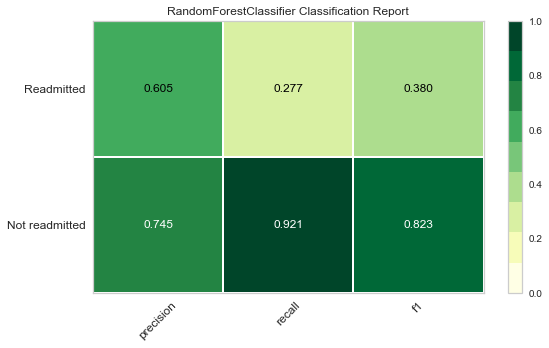

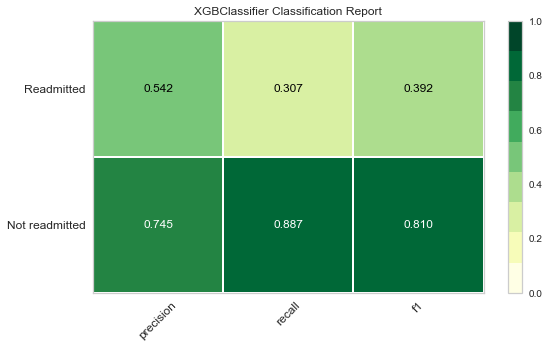

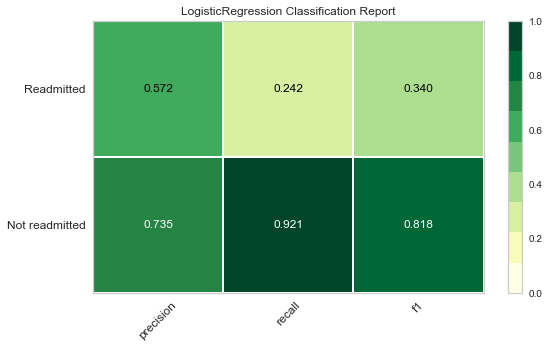

In [129]:
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport

def visualize_model(Xtrain, Xtest, estimator, **kwargs):
    """
    Test various estimators.
    """
    model = Pipeline([
        ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=['Not readmitted', 'Readmitted'],
        cmap="YlGn", size=(600, 360), **kwargs
    )
    visualizer.fit(Xtrain, y_train)
    visualizer.score(Xtest, y_test)
    visualizer.show()
    


for key in final_models.keys():
    
    model, Xtr, Xte = final_models[key]
    
    visualize_model(Xtr, Xte, model)

Looking at outcome-specific performance measures, the gradient boosted tree classifier had the highest recall (0.307) and F1-score (0.392) for admissions resulting in 30-day readmissions.

## Feature importance

AxesSubplot(0.125,0.125;0.775x0.755)
Feature ranking:
1. days_since_last_discharge (0.124633)
2. n_prev_adm (0.071386)
3. age_at_adm (0.071295)
4. n_Lab (0.066651)
5. median_BMI (0.063262)
6. prev_median_BMI (0.063035)
7. n_Med (0.062742)
8. median_diastolic (0.054211)
9. n_CPT (0.054017)
10. median_systolic (0.053875)
11. n_prev_ICD (0.051983)
12. change_in_BMI (0.050664)
13. n_ICD (0.049597)
14. readm (0.047943)
15. length_of_stay (0.038701)
16. max_EGFR (0.013758)
17. Race (0.011377)
18. Sex (0.009573)
19. n_prev_ED_adm (0.009459)
20. prev_median_BMI_ind (0.008503)
21. change_in_BMI_ind (0.006297)
22. median_BMI_ind (0.006265)
23. median_systolic_ind (0.003917)
24. median_diastolic_ind (0.003635)
25. ED (0.002212)
26. preg (0.001007)


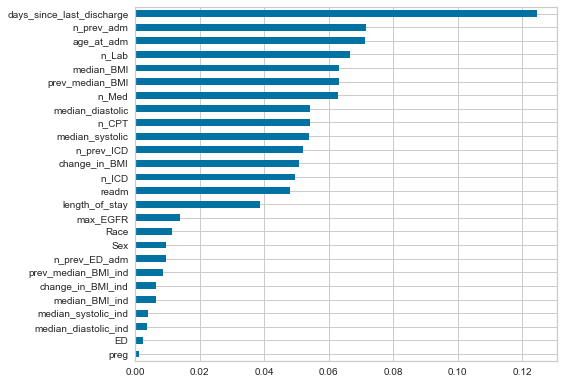

In [130]:
### RF model
prediction_cols = best_rf_model[2][0].columns

print(pd.Series(best_rf_model[0].feature_importances_,
                index=prediction_cols).sort_values().plot.barh())

### to print feature rankings
importances = best_rf_model[0].feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(best_rf_model[2][0].shape[1]):
    print("%d. %s (%f)" % (f + 1, best_rf_model[2][0].columns[indices[f]], importances[indices[f]]))
    
plt.tight_layout();

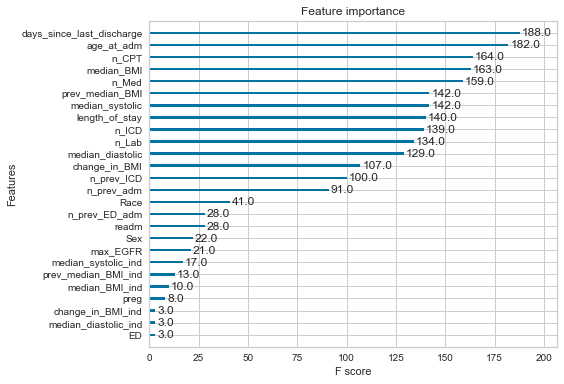

In [131]:
### XGB model
xgb.plot_importance(best_xgb_model[0])
plt.tight_layout();

In [11]:
### Logistic Regression model

print("Model coefficients (odds ratios):\n")
for i in range(X_train_drop.shape[1]):
    print(X_train_drop.columns[i], "=", np.exp(lr.coef_[0][i]).round(4))

Model coefficients (odds ratios):

Sex = 1.0812
Race = 0.9933
days_since_last_discharge = 0.9995
length_of_stay = 0.9877
readm = 2.3536
age_at_adm = 0.9923
ED = 1.0653
n_CPT = 1.0
n_ICD = 1.0015
n_Lab = 1.0064
n_Med = 1.0016
preg = 0.9815
max_EGFR = 0.977
n_prev_ICD = 1.0015
n_prev_adm = 1.0261
n_prev_ED_adm = 0.948


For both the random forest and gradient boosted tree classifiers, the number of days since last discharge and the age at admission were the two most important features. In both models, ED services and pregnancy were among the least important features. In the baseline logistic regression model, whether or not the current admission was a readmission is the strongest predictor of future readmission (odds ratio = 2.35). For the most part, the predictors incorporating information from the current visit were more important in all three models than predictors incorporating information from previous visits. One exception was the number of previous admissions in the random forest model, which was ranked second in importance.

## SHAP values

In [133]:
### RF model
rf_explainer = shap.Explainer(best_rf_model[0].predict,
                              best_rf_model[2][1][:1000]) # limited to first 1000 instances
                                                          # due to large computation time
shap_values_rf = rf_explainer(best_rf_model[2][1][:1000])

Permutation explainer: 1001it [27:19,  1.65s/it]                                


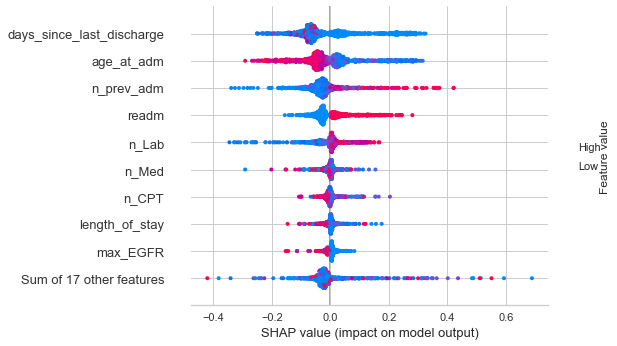

In [134]:
shap.plots.beeswarm(shap_values_rf)

In [135]:
### XGB model
xgb_explainer = shap.TreeExplainer(best_xgb_model[0])
shap_values_xgb = xgb_explainer(best_xgb_model[2][1])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


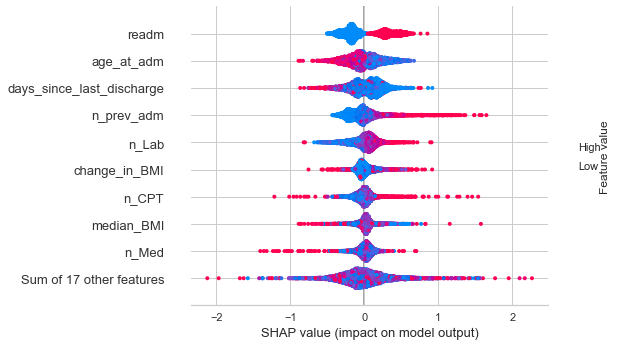

In [136]:
shap.plots.beeswarm(shap_values_xgb)

In [12]:
### Logistic Regression model - odds ratios provide similar information to the SHAP values

print("Model coefficients (odds ratios):\n")
for i in range(X_train_drop.shape[1]):
    print(X_train_drop.columns[i], "=", np.exp(lr.coef_[0][i]).round(4))

Model coefficients (odds ratios):

Sex = 1.0812
Race = 0.9933
days_since_last_discharge = 0.9995
length_of_stay = 0.9877
readm = 2.3536
age_at_adm = 0.9923
ED = 1.0653
n_CPT = 1.0
n_ICD = 1.0015
n_Lab = 1.0064
n_Med = 1.0016
preg = 0.9815
max_EGFR = 0.977
n_prev_ICD = 1.0015
n_prev_adm = 1.0261
n_prev_ED_adm = 0.948


A few patterns in the SHAP value visualizations persisted in both classifiers and are worth noting. First, admissions that were 30-day readmissions were more likely to result in a subsequent 30-day readmission. Second, higher numbers of previous admissions and unique labs were associated with 30-day readmissions. We expected to see the aforementioned associations, since these variables are likely indicative of higher morbidity.

# Conclusion/Discussion
We evaluated the performances of multiple random forest and gradient boosted tree models trained on datasets employing a variety of imputation methods. Since minimizing false negatives was most important, we used the F-beta score (beta = 2) to compare classifier performance. The best-performing model for 30-day readmission was the gradient boosted tree classifier trained on data imputed using the most frequent value. 

This project had several limitations. First, ICD codes from the current admission were included in our classifiers, even though most (if not all) ICD codes are assigned at discharge [4]. CPT codes from the current visit may not be available at the time of discharge either. Future work may involve removing these variables from the model, such that the model considers the data reliably available at the time of prediction and a more parsimonious model can be reached. Second, only the unique numbers of ICD codes, CPT codes, labs, and medications were modeled. While this method of reshaping the data tolerates more messiness in the data (e.g., data entry errors), this simplification does not capture the potential morbidity leading to different clinical decisions. Future work might also incorporate comorbidity scores during admission or the occurrences of specific clinical events.

# References

[1] Joynt, Karen E., and Ashish K. Jha. “Thirty-Day Readmissions — Truth and Consequences.” New England Journal of Medicine 366, no. 15 (April 12, 2012): 1366–69. https://doi.org/10.1056/NEJMp1201598.

[2] “Hosp. Readmission Reduction | CMS.” Accessed April 19, 2022. https://www.cms.gov/Medicare/Quality-Initiatives-Patient-Assessment-Instruments/Value-Based-Programs/HRRP/Hospital-Readmission-Reduction-Program.

[3] Mahmoudi, Elham, Neil Kamdar, Noa Kim, Gabriella Gonzales, Karandeep Singh, and Akbar K. Waljee. “Use of Electronic Medical Records in Development and Validation of Risk Prediction Models of Hospital Readmission: Systematic Review.” BMJ 369 (April 8, 2020): m958. https://doi.org/10.1136/bmj.m958.

[4] Walsh, Colin G., Kavya Sharman, and George Hripcsak. “Beyond Discrimination: A Comparison of Calibration Methods and Clinical Usefulness of Predictive Models of Readmission Risk.” Journal of Biomedical Informatics 76 (December 2017): 9–18. https://doi.org/10.1016/j.jbi.2017.10.008.
